(1e-05, 0.12345491844669709)

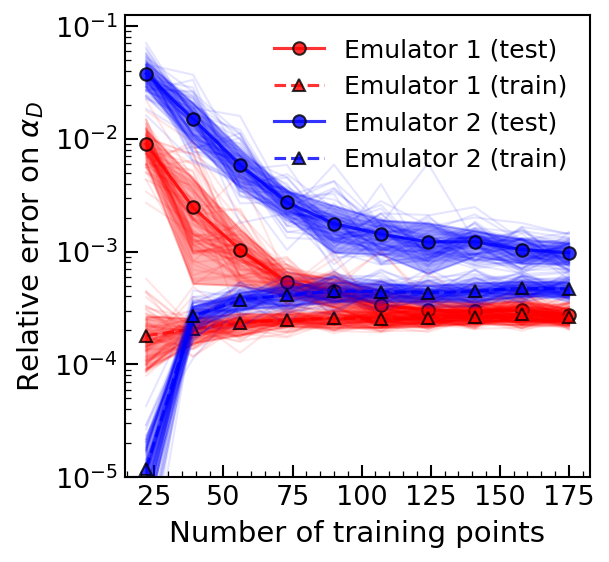

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

# Training sizes (per tier)
n = [22, 39, 56, 73, 90, 107, 124, 141, 158, 175]
n = [22, 39, 56, 73, 90, 107, 124, 141, 158, 175]
tiers = range(1, 11)
seeds = [123+i for i in range(100)]





mpl.rcParams.update({
    # Ticks pointing inward on both axes
    "xtick.direction": "in",
    "ytick.direction": "in",


    # Make minor ticks visible too
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,

    # Tick lengths/widths (optional, tweak as you like)
    "xtick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.major.size": 6,
    "ytick.minor.size": 3,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,

    # Increase tick-label font size
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,

    # (Nice to have) larger axis labels/titles globally
    "axes.labelsize": 14,
    "axes.titlesize": 14,
})







def emulator_stats_and_curves(em_tag, color, label, sets, lsl, marker ):
    """
    Load all seeds for an emulator, return mean and std across seeds.
    Also plot the individual seed curves in light gray.
    """
    per_seed_means = []
    for seed in seeds:
        seed_means = []
        for i in tiers:
            df = pd.read_csv(f"../dipoles_exp_param/alphaD_eval_{em_tag}_{seed}/alphaD_relerr_{sets}_tier{i}.csv")
            seed_means.append(df["rel_abs"].to_numpy().mean())
        per_seed_means.append(seed_means)
        # plot this seed in light gray
        plt.plot(n, seed_means, '-', color=color, linewidth=1, alpha=0.1)

    per_seed_means = np.asarray(per_seed_means)  # shape (4, 10)
    mean = per_seed_means.mean(axis=0)
    std  = per_seed_means.std(axis=0)
    
    # plot mean + band
    plt.plot(n, mean, marker = marker, color=color, label=f'{label}', ls = lsl, mec = 'black', alpha = 0.8)
    plt.fill_between(n, mean - std, mean + std, color=color, alpha=0.3)
    
    return mean, std

# ---- Plot ----
plt.figure(figsize=(4,4), dpi = 150)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(25))

# Em1 (blue)
em1_mean, em1_std = emulator_stats_and_curves("Em1", color="red", label="Emulator 1 (test)", sets="test", lsl = '-',
                                             marker = 'o')

# Em2 (orange)
em2_mean, em2_std = emulator_stats_and_curves("Em1", color="red", label="Emulator 1 (train)", sets="train", lsl = '--',
                                             marker = '^')


#Em1 (blue)
em1_mean, em1_std = emulator_stats_and_curves("Em2", color="blue", label="Emulator 2 (test)", sets="test", 
                                              lsl = '-', marker = 'o')

# Em2 (orange)
em2_mean, em2_std = emulator_stats_and_curves("Em2", color="blue", label="Emulator 2 (train)", sets="train", lsl = '--',
                                             marker = '^')




plt.yscale('log')
plt.ylabel(r'Relative error on $\alpha_D$')
plt.xlabel('Number of training points')
plt.legend(frameon=False)
plt.ylim(1e-5)


#plt.savefig('NumberOfTrain.pdf', bbox_inches='tight')


Saved figure to NumberOfTrain.pdf


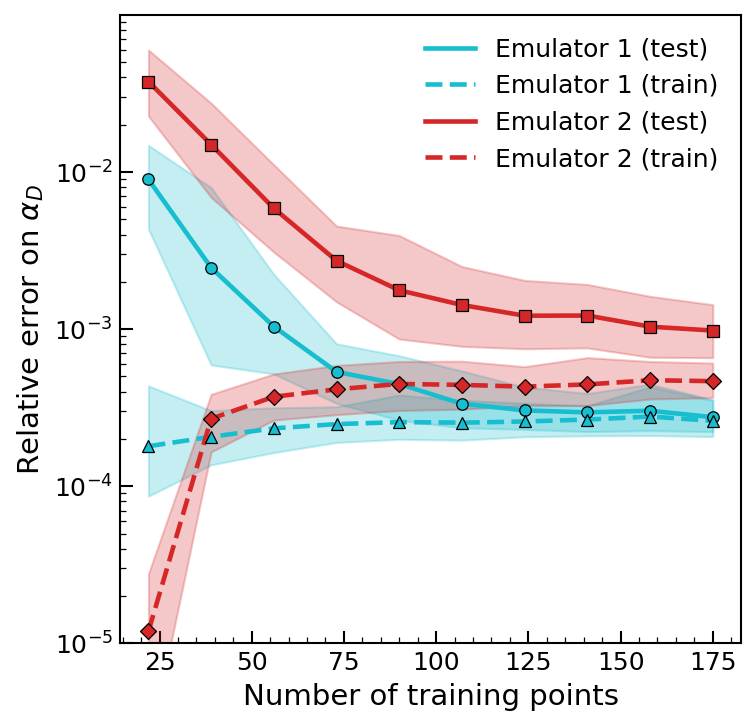

In [111]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ========= User config =========
n = [22, 39, 56, 73, 90, 107, 124, 141, 158, 175]
tiers = range(1, 11)
seeds = [123 + i for i in range(100)]

# CSV layout:
# ../dipoles_exp_param/alphaD_eval_{Em1|Em2}_{seed}/alphaD_relerr_{test|train}_tier{i}.csv
root_fmt = "../dipoles_exp_param/alphaD_eval_{em_tag}_{seed}/alphaD_relerr_{sets}_tier{tier}.csv"

# --- emulator brand colors ---
EM1_COLOR = "#17becf"   # Emulator 1
EM2_COLOR = "#d62728"   # Emulator 2

OUT_FIG = "NumberOfTrain.pdf"
# ===============================

# ---- Matplotlib look/feel ----
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.titlesize": 15,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.major.size": 6,
    "ytick.minor.size": 3,
    "axes.grid": False,
    "grid.alpha": 0.25,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# ---- Optional light smoothing (prefers Savitzky–Golay) ----
try:
    from scipy.signal import savgol_filter
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def _moving_avg(y, k=3):
    """Tiny moving average with edge padding (very gentle)."""
    y = np.asarray(y, float)
    if k <= 1 or len(y) < 3:
        return y
    pad = k // 2
    ypad = np.pad(y, (pad, pad), mode="edge")
    kernel = np.ones(k) / k
    return np.convolve(ypad, kernel, mode="valid")

def _light_smooth(y, window=3, poly=2):
    """
    Very mild smoothing on original grid.
    - If SciPy: Savitzky–Golay with tiny window.
    - Else: moving average with window k.
    """
    y = np.asarray(y, float)
    window = max(3, int(window))         # ensure >=3
    if window % 2 == 0:
        window += 1                       # SavGol needs odd window
    if len(y) < window:
        # fall back to k=3 moving average if too short
        return _moving_avg(y, k=min(3, len(y)))
    if _HAS_SCIPY and window > poly:
        return savgol_filter(y, window_length=window, polyorder=min(poly, window-1))
    return _moving_avg(y, k=window)

# ---- Data loader for one emulator/setting ----
def collect_seed_curves(em_tag: str, sets: str):
    """Returns per-seed arrays of mean rel_abs per tier. Skips incomplete seeds."""
    per_seed = []
    for seed in seeds:
        ok = True
        vals = []
        for t in tiers:
            csv_path = root_fmt.format(em_tag=em_tag, seed=seed, sets=sets, tier=t)
            if not os.path.exists(csv_path):
                ok = False
                break
            df = pd.read_csv(csv_path)
            vals.append(df["rel_abs"].to_numpy().mean())
        if ok:
            per_seed.append(np.asarray(vals, dtype=float))
    return per_seed

# ---- Plotting helper: lightly-smoothed band & mean on original grid ----
def plot_emulator_with_band(n_vals, em_tag, sets, color, label,
                            line_style="-", marker="o",
                            alpha_band=0.25, lw=2.2,
                            smooth_window=3,  # <-- tweak to 5 for a touch more smoothing
                            draw_seed_traces=False):
    per_seed = collect_seed_curves(em_tag, sets)
    if len(per_seed) == 0:
        print(f"[WARN] No complete seed curves found for {em_tag} / {sets}. Skipping.")
        return np.full(len(n_vals), np.nan), (np.full(len(n_vals), np.nan), np.full(len(n_vals), np.nan))

    per_seed = np.vstack(per_seed)  # (num_seeds, num_tiers)

    # Optional faint seed traces at original grid (unsmoothed)
    if draw_seed_traces:
        for row in per_seed:
            plt.plot(n_vals, row, "-", color=color, alpha=0.08, lw=1.0, zorder=1)

    # Statistics at original grid
    mean = per_seed.mean(axis=0)
    lo95 = np.percentile(per_seed, 2.5, axis=0)
    hi95 = np.percentile(per_seed, 97.5, axis=0)

    # Light smoothing on ORIGINAL GRID (no interpolation)
    mean_s  = _light_smooth(mean,  window=smooth_window, poly=2)
    lo95_s  = _light_smooth(lo95,  window=smooth_window, poly=2)
    hi95_s  = _light_smooth(hi95,  window=smooth_window, poly=2)

    # Keep band sane: ensure lo <= hi after smoothing
    lo95_s = np.minimum(lo95_s, hi95_s)
    hi95_s = np.maximum(hi95_s, lo95_s)

    # 95% BAND: original x, lightly smoothed y
    plt.fill_between(n_vals, lo95_s, hi95_s, color=color, alpha=alpha_band, zorder=2)

    # CENTRAL LINE: lightly smoothed, markers on the original mean (optional)
    plt.plot(n_vals, mean_s, color=color, linestyle=line_style, lw=lw, label=label, zorder=3)
    plt.plot(n_vals, mean, marker=marker, linestyle="none", color=color,
             mec="black", mew=0.6, markersize=5.5, zorder=4)

    return mean_s, (lo95_s, hi95_s)

# ================== Figure ==================
fig, ax = plt.subplots(figsize=(5.2, 5.0))
ax.set_yscale("log")
ax.set_xlabel("Number of training points", size=14)
ax.set_ylabel(r"Relative error on $\alpha_D$", size=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

# Emulator 1
plot_emulator_with_band(n, "Em1", "test",  EM1_COLOR, "Emulator 1 (test)",  "-",  "o", smooth_window=3)
plot_emulator_with_band(n, "Em1", "train", EM1_COLOR, "Emulator 1 (train)", "--", "^", smooth_window=3)

# Emulator 2
plot_emulator_with_band(n, "Em2", "test",  EM2_COLOR, "Emulator 2 (test)",  "-",  "s", smooth_window=3)
plot_emulator_with_band(n, "Em2", "train", EM2_COLOR, "Emulator 2 (train)", "--", "D", smooth_window=3)

ax.legend(frameon=False, loc="upper right", ncol=1)
ax.set_ylim(1e-5, None)

plt.tight_layout()
fig.savefig(OUT_FIG, bbox_inches="tight")
print(f"Saved figure to {OUT_FIG}")
plt.show()


Saved figure to NumberOfTrain.pdf


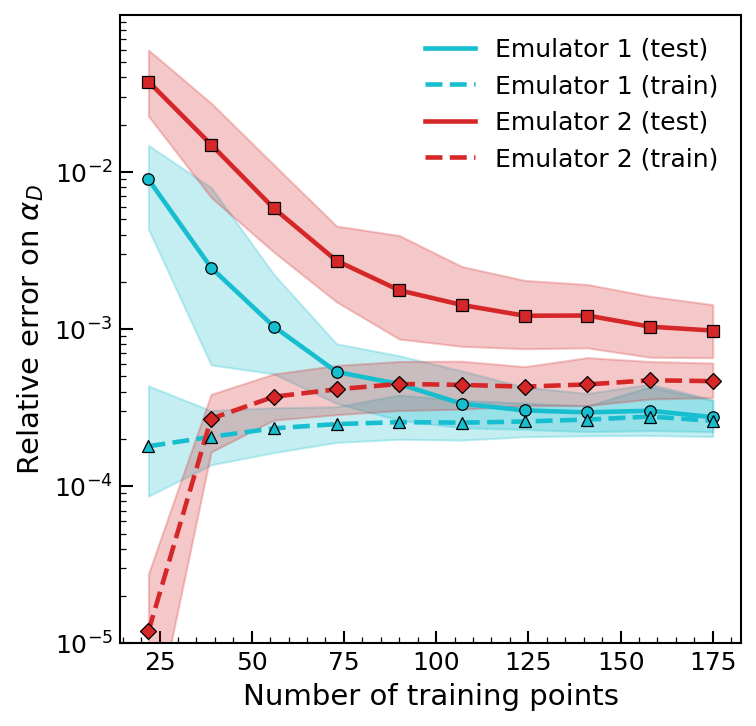

In [108]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ========= User config =========
n = [22, 39, 56, 73, 90, 107, 124, 141, 158, 175]
tiers = range(1, 11)
seeds = [123 + i for i in range(100)]

# CSV layout:
# ../dipoles_exp_param/alphaD_eval_{Em1|Em2}_{seed}/alphaD_relerr_{test|train}_tier{i}.csv
root_fmt = "../dipoles_exp_param/alphaD_eval_{em_tag}_{seed}/alphaD_relerr_{sets}_tier{tier}.csv"

# --- emulator brand colors ---
EM1_COLOR = "#17becf"   # Emulator 1
EM2_COLOR = "#d62728"   # Emulator 2

OUT_FIG = "NumberOfTrain.pdf"
# ===============================

# ---- Matplotlib look/feel ----
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.titlesize": 15,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.major.size": 6,
    "ytick.minor.size": 3,
    "axes.grid": False,
    "grid.alpha": 0.25,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# ---- Data loader for one emulator/setting ----
def collect_seed_curves(em_tag: str, sets: str):
    """Returns per-seed arrays of mean rel_abs per tier. Skips incomplete seeds."""
    per_seed = []
    for seed in seeds:
        ok = True
        vals = []
        for t in tiers:
            csv_path = root_fmt.format(em_tag=em_tag, seed=seed, sets=sets, tier=t)
            if not os.path.exists(csv_path):
                ok = False
                break
            df = pd.read_csv(csv_path)
            vals.append(df["rel_abs"].to_numpy().mean())
        if ok:
            per_seed.append(np.asarray(vals, dtype=float))
    return per_seed

# ---- Plotting helper: 95% band on ORIGINAL grid (no interpolation/smoothing) ----
def plot_emulator_with_band(n_vals, em_tag, sets, color, label,
                            line_style="-", marker="o",
                            alpha_band=0.25, lw=2.2,
                            draw_seed_traces=False):
    per_seed = collect_seed_curves(em_tag, sets)
    if len(per_seed) == 0:
        print(f"[WARN] No complete seed curves found for {em_tag} / {sets}. Skipping.")
        return np.full(len(n_vals), np.nan), (np.full(len(n_vals), np.nan), np.full(len(n_vals), np.nan))

    per_seed = np.vstack(per_seed)  # (num_seeds, num_tiers)

    # Optional faint seed traces at original grid
    if draw_seed_traces:
        for row in per_seed:
            plt.plot(n_vals, row, "-", color=color, alpha=0.08, lw=1.0, zorder=1)

    # Statistics at original grid
    mean = per_seed.mean(axis=0)
    lo95 = np.percentile(per_seed, 2.5, axis=0)
    hi95 = np.percentile(per_seed, 97.5, axis=0)

    # 95% BAND: plotted directly on original x coordinates (no dense grid, no smoothing)
    plt.fill_between(n_vals, lo95, hi95, color=color, alpha=alpha_band, zorder=2)

    # CENTRAL LINE: only on original points
    plt.plot(n_vals, mean, color=color, linestyle=line_style, lw=lw, label=label, zorder=3)
    plt.plot(n_vals, mean, marker=marker, linestyle="none", color=color,
             mec="black", mew=0.6, markersize=5.5, zorder=4)

    return mean, (lo95, hi95)

# ================== Figure ==================
fig, ax = plt.subplots(figsize=(5.2, 5.0))
ax.set_yscale("log")
ax.set_xlabel("Number of training points", size=14)
ax.set_ylabel(r"Relative error on $\alpha_D$", size=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

# Emulator 1
plot_emulator_with_band(n, "Em1", "test",  EM1_COLOR, "Emulator 1 (test)",  "-",  "o")
plot_emulator_with_band(n, "Em1", "train", EM1_COLOR, "Emulator 1 (train)", "--", "^")

# Emulator 2
plot_emulator_with_band(n, "Em2", "test",  EM2_COLOR, "Emulator 2 (test)",  "-",  "s")
plot_emulator_with_band(n, "Em2", "train", EM2_COLOR, "Emulator 2 (train)", "--", "D")

ax.legend(frameon=False, loc="upper right", ncol=1)
ax.set_ylim(1e-5, None)

plt.tight_layout()
fig.savefig(OUT_FIG, bbox_inches="tight")
print(f"Saved figure to {OUT_FIG}")
plt.show()


# 